## Generate plots of azimuthally averaged disc properties which can be calculated from the disc properties available in pyphantom (e.g. toomre parameter, surface density, temperature, sound speed).

In [1]:
import os,sys
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import PIL.Image as Image

In [2]:
sys.path.insert(0,'../phantom_files')
from libanalysis import PhantomAnalysis as pa
sys.path.insert(0,'../modules')
import phantom

In [3]:
all_end_dumps = []
for r,d,files in os.walk('..'):
    all_dumps = [os.path.join(r,f) for f in files if 'sgdisc_' in f]
    if all_dumps:
        all_end_dumps.append(sorted(all_dumps)[-1])

In [4]:
UNITS = phantom.get_units()

In [5]:
UNITS

{'udens': 5.94103125029151e-07,
 'udist': 14960000000000.0,
 'uerg': 8871227776136.363,
 'umass': 1.9891e+33,
 'utime': 5022728.790082334,
 'uvel': 2978460.6386750126,
 'yr': 0.1591606709661804}

In [6]:
# folder containing thermodynamic .dat files outputted from phantom
# (these are the files created during phantom.generate_u_udot_file())
out_dir = '../u_and_udot_files'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [7]:
def plot_results_in_grid(out_dict,plots_stuff):
    fig,ax = plt.subplots(2,3,figsize=(20,10))
    i = 0
    j = 0
    for key, values in out_dict.items():
        if key == 'r':
            continue
        if i>2:
            i=0
            j+=1
        ax[j,i].plot(out_dict['r'],values)
        ax[j,i].set_title(key)
        ax[j,i].set_ylim(plots_stuff['ylimits'][key])
        ax[j,i].set_xlim(plots_stuff['xlimits'][key])
        ax[j,i].set_ylabel(plots_stuff['ylabels'][key])
        ax[j,i].set_xlabel('R (AU)')
        ax[j,i].grid(alpha=0.25)
        i+=1
    plt.show()

In [8]:
def plot_multidumps(out_dicts,plots_stuff,key,legend):
    
    fig = plt.figure(figsize=(12,6))
    for out_dict in out_dicts:
        plt.plot(out_dict['r'],out_dict[key])
    plt.xlabel('R (AU)')
    plt.ylabel(plots_stuff['ylabels'][key])
    plt.ylim(plots_stuff['ylimits'][key])
    plt.xlim(plots_stuff['xlimits'][key])
    plt.grid(alpha=0.25)
    plt.legend(legend)
    
    return fig

In [14]:
plots_stuff = {
    'ylimits' : {
        'temp' : [0,30],
        'sigma' : [0,100],
        'npart' : [0,22000],
        'cs' : [0,40000],
        'omega' : [0,2e-7],
        'toomre' : [0,5],
        'utherm' : [0,2e9],
        'u' : [0,2e9],
        'udot' : [-1e-7,2.5e-7],
        'tcool' : [-1e-7,2.5e-7]
    },
    'xlimits' : {
        'temp' : [5,100],
        'sigma' : [5,100],
        'npart' : [5,100],
        'cs' : [5,100],
        'omega' : [0,100],
        'toomre' : [5,100],
        'utherm' : [0,100],
        'u' : [0,100],
        'udot' : [0,100],
        'tcool' : [0,100]
    },
    'ylabels' : {
        'temp' : 'Temperature (K)',
        'sigma' : r'$\Sigma$ (g/cm$^2$)',
        'npart' : 'Npart',
        'cs' : r'c$_s$ (m/s)',
        'omega' : r'$\Omega$ (s$^-1$)',
        'toomre' : 'Q',
        'utherm' : 'u (erg/g)',
        'u' : 'u (erg/g)',
        'udot' : 'du/dt (erg/g/s)',
        'tcool' : 's'
    }
}

### Plot disc properties at a time close to when the a=250AU disc fragments, and compare them to the a=500AU disc and the corresponding reference run case.

In [55]:
dumps = [
    '../a250/mdisc0.2/extra_dumps/sgdisc_00026',
    '../a500/mdisc0.2/extra_dumps/sgdisc_00065',
    '../single/mdisc0.2/extra_dumps/sgdisc_00020'
]

pyphantom_dicts = {}
thermodynamics_dicts = {}
splash_plots = {}
for dump in dumps:
    fid = phantom.folder_id(dump)
    # read dump
    disc = phantom.read_dump_file(dump)
    # get azimuthally averaged disc properties from pyphantom disc instance
    out = phantom.get_az_averaged_properties(disc)
    pyphantom_dicts[dump] = out
    # get azimuthally averaged u, du/dt, tcool etc. which aren't available in pyphantom
    plot_id = 'u_and_udot_' + fid + '.dat'
    outfile = os.path.join(out_dir,plot_id)
    if not os.path.exists(outfile):
        phantom.generate_u_udot_file(dump,outfile)
    u_and_udot_raw_data = phantom.read_u_udot_file(outfile)
    u_and_udot = phantom.get_az_averaged_u_udot(u_and_udot_raw_data)
    thermodynamics_dicts[dump] = u_and_udot
    # also load and cache splash disc plot.
    dir_id = phantom.folder_id(os.path.dirname(dump))
    fname = dir_id + '_' + dump.split('/')[-1]
    outfile = os.path.join('../extra_disc_plots',fname+'.png')
    if not os.path.exists(os.path.join(outfile)):
        phantom.generate_png_plot(dump,outfile)
    im = Image.open(outfile)
    splash_plots[dump] = im

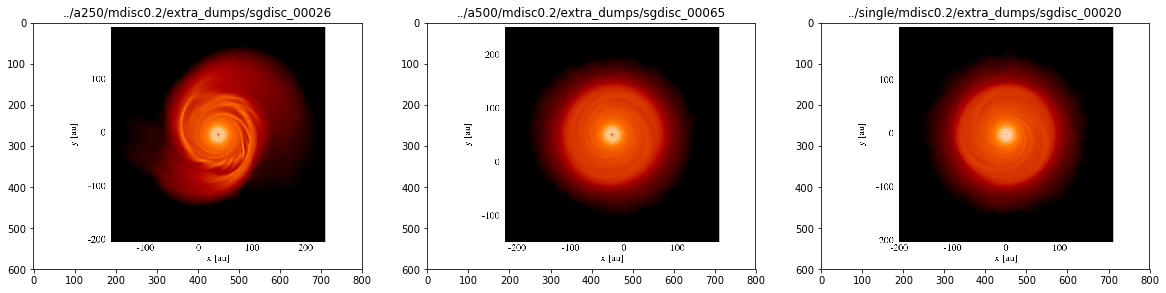

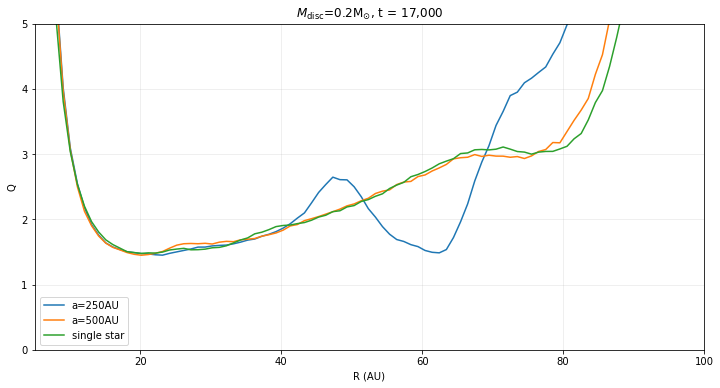

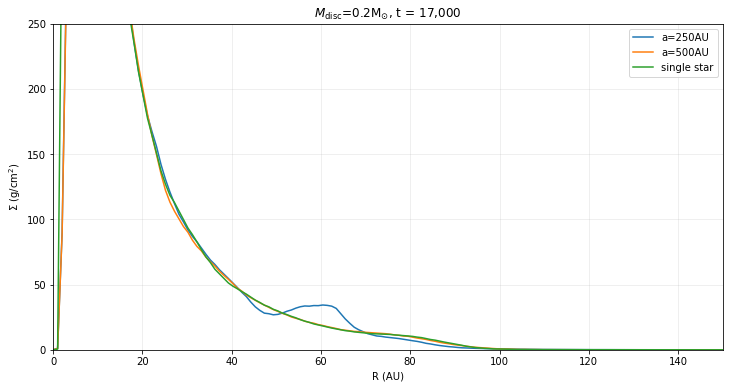

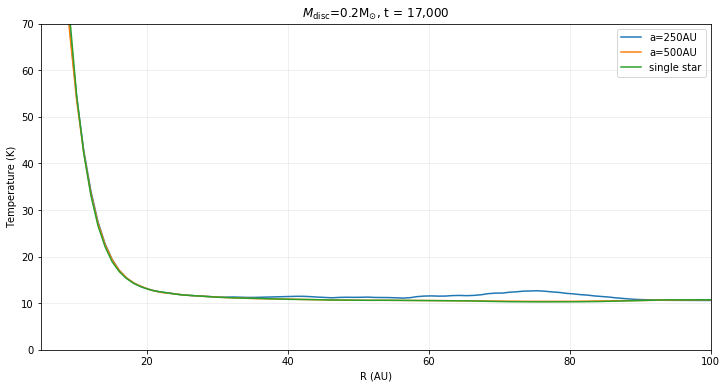

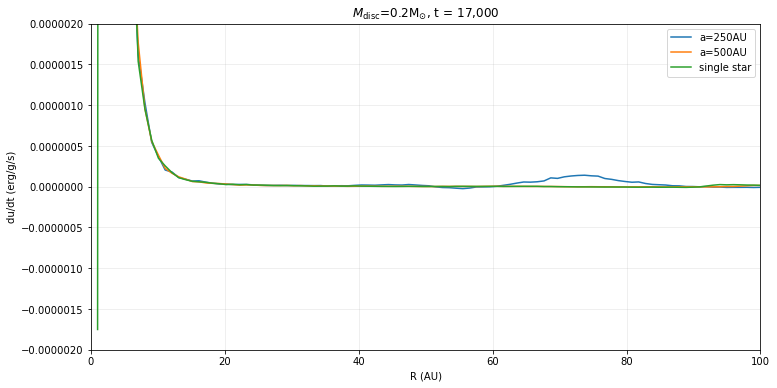

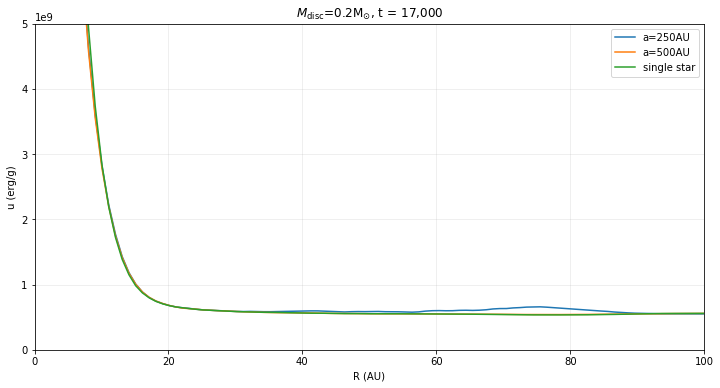

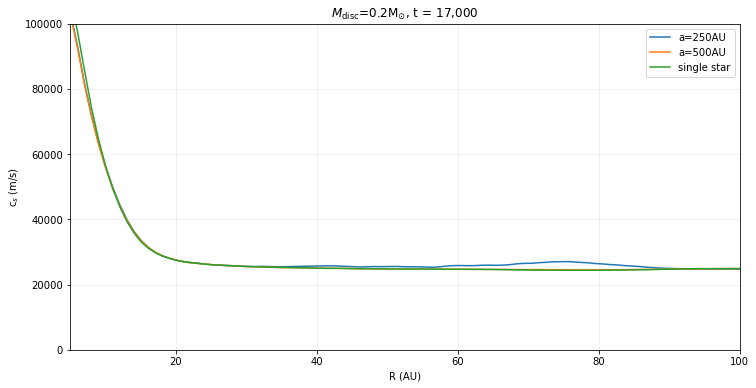

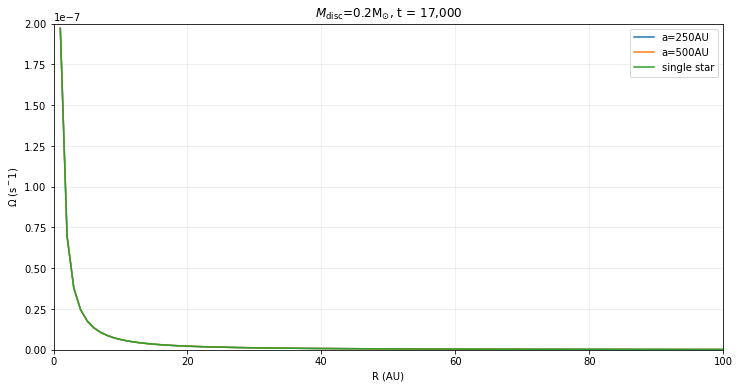

In [56]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(20,10))
for i, (fname, image) in enumerate(splash_plots.items()):
    ax[i].imshow(image)
    ax[i].set_title(fname)
plt.show()
    
legend = ['a=250AU', 'a=500AU', 'single star']

dumps_to_plot = [
    '../a250/mdisc0.2/extra_dumps/sgdisc_00026',
    '../a500/mdisc0.2/extra_dumps/sgdisc_00065',
    '../single/mdisc0.2/extra_dumps/sgdisc_00020'
]

pyphantom_dicts_to_plot = [pyphantom_dicts[dump] for dump in dumps_to_plot]
thermodynamics_dicts_to_plot = [thermodynamics_dicts[dump] for dump in dumps_to_plot]

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'toomre',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, t = 17,000')
plt.show()

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'sigma',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, t = 17,000')
plt.show()

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'temp',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, t = 17,000')
plt.show()

fig = plot_multidumps(thermodynamics_dicts_to_plot,plots_stuff,'udot',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, t = 17,000')
plt.show()

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'utherm',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, t = 17,000')
plt.show()

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'cs',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, t = 17,000')
plt.show()

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'omega',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, t = 17,000')
plt.show()

## plotting how disc properties vary throughout a binary star's orbit with eccentricity, which eventually fragments

In [42]:
dumps = [
    '../a325/mdisc0.2/sgdisc_00205',
    '../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00010',
    '../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00020',
    '../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00073',
    '../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00077',
    '../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00078',
    '../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00079',
    '../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00080'
]

pyphantom_dicts = {}
thermodynamics_dicts = {}
splash_plots = {}
for dump in dumps:
    fid = phantom.folder_id(dump)
    # read dump
    disc = phantom.read_dump_file(dump)
    # get azimuthally averaged disc properties from pyphantom disc instance
    out = phantom.get_az_averaged_properties(disc)
    pyphantom_dicts[dump] = out
    # get azimuthally averaged u, du/dt, tcool etc. which aren't available in pyphantom
    plot_id = 'u_and_udot_' + fid + '.dat'
    outfile = os.path.join(out_dir,plot_id)
    if not os.path.exists(outfile):
        phantom.generate_u_udot_file(dump,outfile)
    u_and_udot_raw_data = phantom.read_u_udot_file(outfile)
    u_and_udot = phantom.get_az_averaged_u_udot(u_and_udot_raw_data)
    thermodynamics_dicts[dump] = u_and_udot
    # also load and cache splash disc plot.
    dir_id = phantom.folder_id(os.path.dirname(dump))
    fname = dir_id + '_' + dump.split('/')[-1]
    outfile = os.path.join('../extra_disc_plots',fname+'.png')
    if not os.path.exists(os.path.join(outfile)):
        phantom.generate_png_plot(dump,outfile)
    im = Image.open(outfile)
    splash_plots[dump] = im

In [43]:
plots_stuff['ylimits'] = {
        'temp' : [0,70],
        'sigma' : [0,250],
        'npart' : [0,22000],
        'cs' : [0,100000],
        'omega' : [0,2e-7],
        'toomre' : [0,5],
        'utherm' : [0,5e9],
        'u' : [0,5e9],
        'udot' : [-2e-6,2e-6],
        'tcool' : [-1e-7,2.5e-7]
    }

../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00073
../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00078
../a325/mdisc0.2/sgdisc_00205


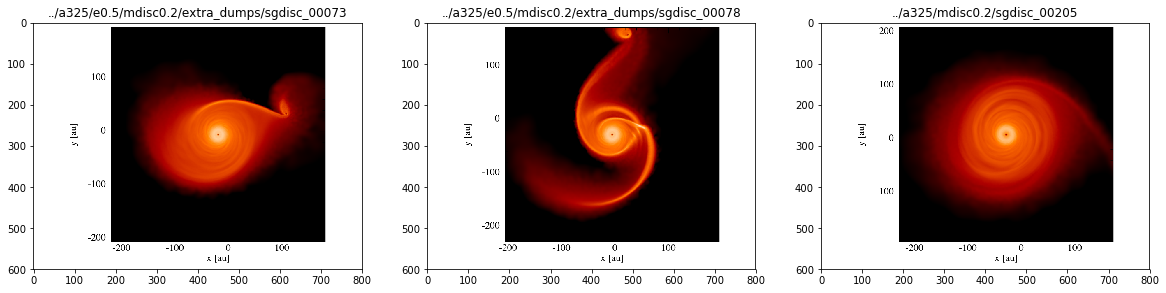

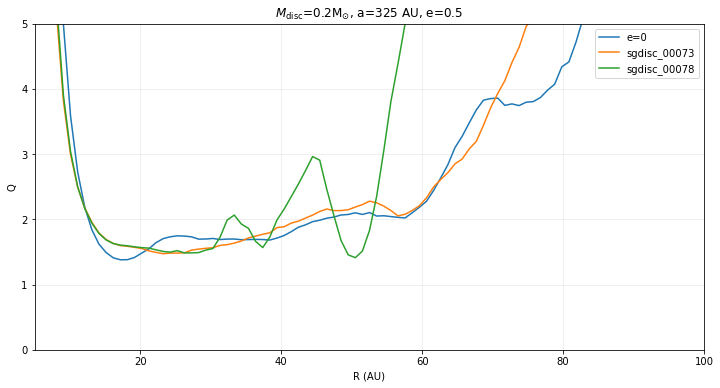

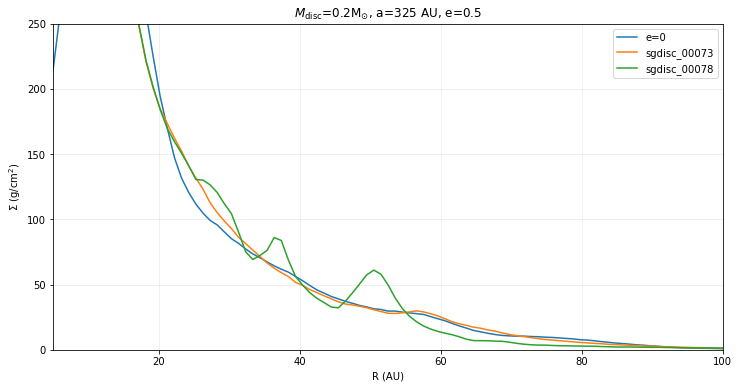

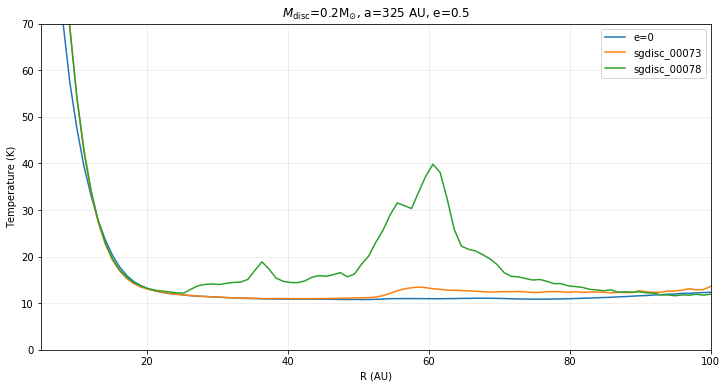

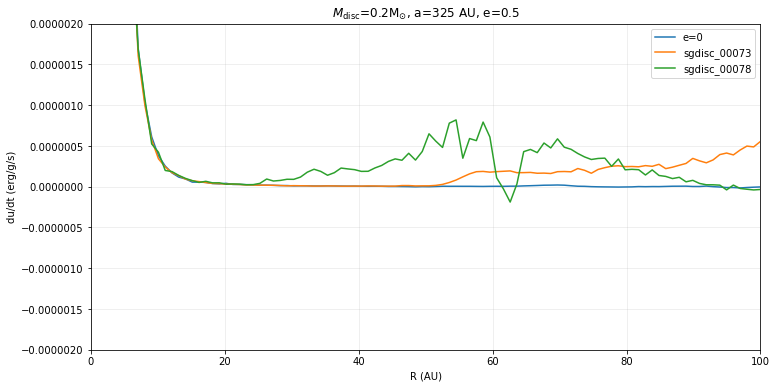

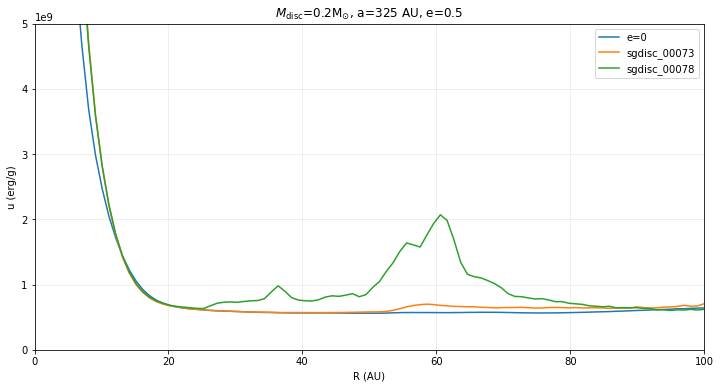

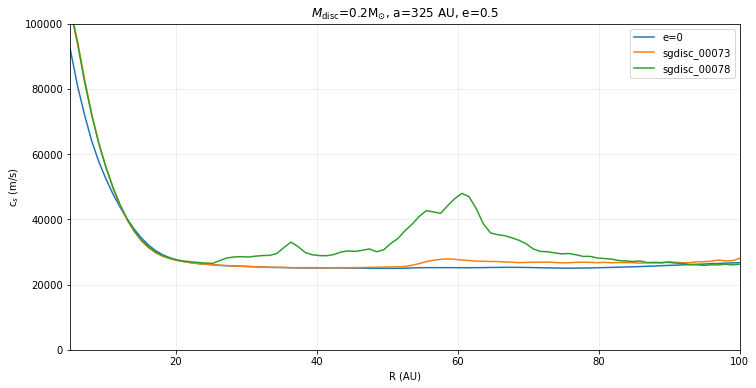

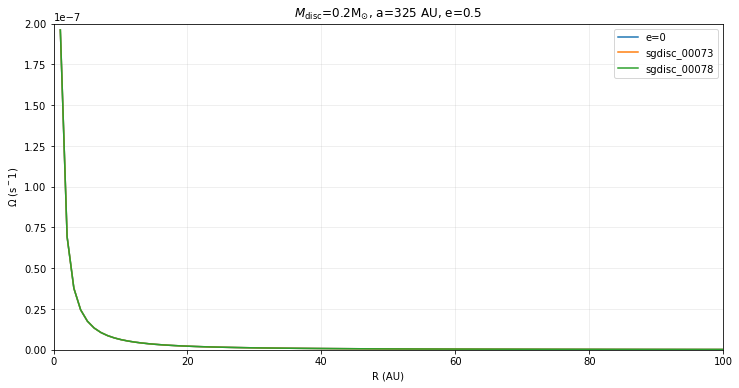

In [51]:
# plot the results
legend = ['e=0', 'sgdisc_00073', 'sgdisc_00078']

plot_dumps = [
    '../a325/mdisc0.2/sgdisc_00205',
    '../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00073',
    '../a325/e0.5/mdisc0.2/extra_dumps/sgdisc_00078'
]

splash_plots_to_plot = {dump:splash_plots[dump] for dump in plot_dumps}

# plot the results
fig,ax = plt.subplots(1,3,figsize=(20,10))
i=0
j=0
for fname, image in sorted(splash_plots_to_plot.items()):
    print(fname)
    ax[i].imshow(image)
    ax[i].set_title(fname)
    i+=1
    if i==3:
        i=0
        j+=1
plt.show()

pyphantom_dicts_to_plot = [pyphantom_dicts[dump] for dump in plot_dumps]
thermodynamics_dicts_to_plot = [thermodynamics_dicts[dump] for dump in plot_dumps]

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'toomre',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, a=325 AU, e=0.5')
plt.show()

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'sigma',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, a=325 AU, e=0.5')
plt.show()

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'temp',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, a=325 AU, e=0.5')
plt.show()

fig = plot_multidumps(thermodynamics_dicts_to_plot,plots_stuff,'udot',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, a=325 AU, e=0.5')
plt.show()

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'utherm',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, a=325 AU, e=0.5')
plt.show()

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'cs',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, a=325 AU, e=0.5')
plt.show()

fig = plot_multidumps(pyphantom_dicts_to_plot,plots_stuff,'omega',legend)
plt.title(r'$M_{\rm disc}$=0.2M$_{\odot}$, a=325 AU, e=0.5')
plt.show()